In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import monai
from PIL import Image
import glob
import monai.transforms as MT
from preproc import *
import argparse
from fetch.viz import m3d, show

from sam2.build_sam import build_sam2_video_predictor
import numpy as np

In [3]:
ret = proc_folder('/home/asy51/tmp/ccf/10735/knee_contra')

/mnt/vstor/CSE_CSDS_VXC204/asy51/miniconda3/envs/sam2/lib/python3.10/site-packages/monai/transforms/intensity/array.py:996: Warning: Divide by zero (a_min == a_max)
  warn("Divide by zero (a_min == a_max)", Warning)


In [4]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument('-m', '--model', type=str, default='l')
opt = parser.parse_args(['-m', 'l'])

if opt.model == 't':
    sam2_checkpoint = "/home/asy51/repos/segment-anything-2/checkpoints/sam2_hiera_tiny.pt"
    model_cfg = "sam2_hiera_t.yaml"
if opt.model == 's':
    sam2_checkpoint = "/home/asy51/repos/segment-anything-2/checkpoints/sam2_hiera_small.pt"
    model_cfg = "sam2_hiera_s.yaml"
if opt.model == 'l':
    sam2_checkpoint = "/home/asy51/repos/segment-anything-2/checkpoints/sam2_hiera_large.pt"
    model_cfg = "sam2_hiera_l.yaml"
if opt.model == 'b':
    sam2_checkpoint = "/home/asy51/repos/segment-anything-2/checkpoints/sam2_hiera_base_plus.pt"
    model_cfg = "sam2_hiera_b+.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)


In [8]:

src = f"{ret['root']}/ax"
prompt_ndx = ret['ax_ndx']
prompt = ret['ax_mask']

inference_state = predictor.init_state(video_path=src)
predictor.reset_state(inference_state)
predictor.add_new_mask(
    inference_state=inference_state,
    frame_idx=prompt_ndx,
    obj_id=0,
    mask=prompt,
)
pred = {}
for slc_ndx, obj_ids, pred_logits in predictor.propagate_in_video(inference_state, start_frame_idx=prompt_ndx):
    pred[slc_ndx] = (pred_logits > 0.0).cpu().numpy() # binarize pred_logits

for slc_ndx, obj_ids, pred_logits in predictor.propagate_in_video(inference_state, start_frame_idx=prompt_ndx, reverse=True):
    pred[slc_ndx] = (pred_logits > 0.0).cpu().numpy() # binarize pred_logits

pred = np.concatenate([pred[slc_ndx] for slc_ndx in sorted(pred.keys())]).squeeze()

propagate in video: 100%|██████████| 157/157 [00:07<00:00, 20.47it/s]


In [14]:
ret['img'].moveaxis(2,0).shape, pred.shape

(torch.Size([320, 160, 304]), (320, 160, 304))

(<Figure size 3000x3000 with 324 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        

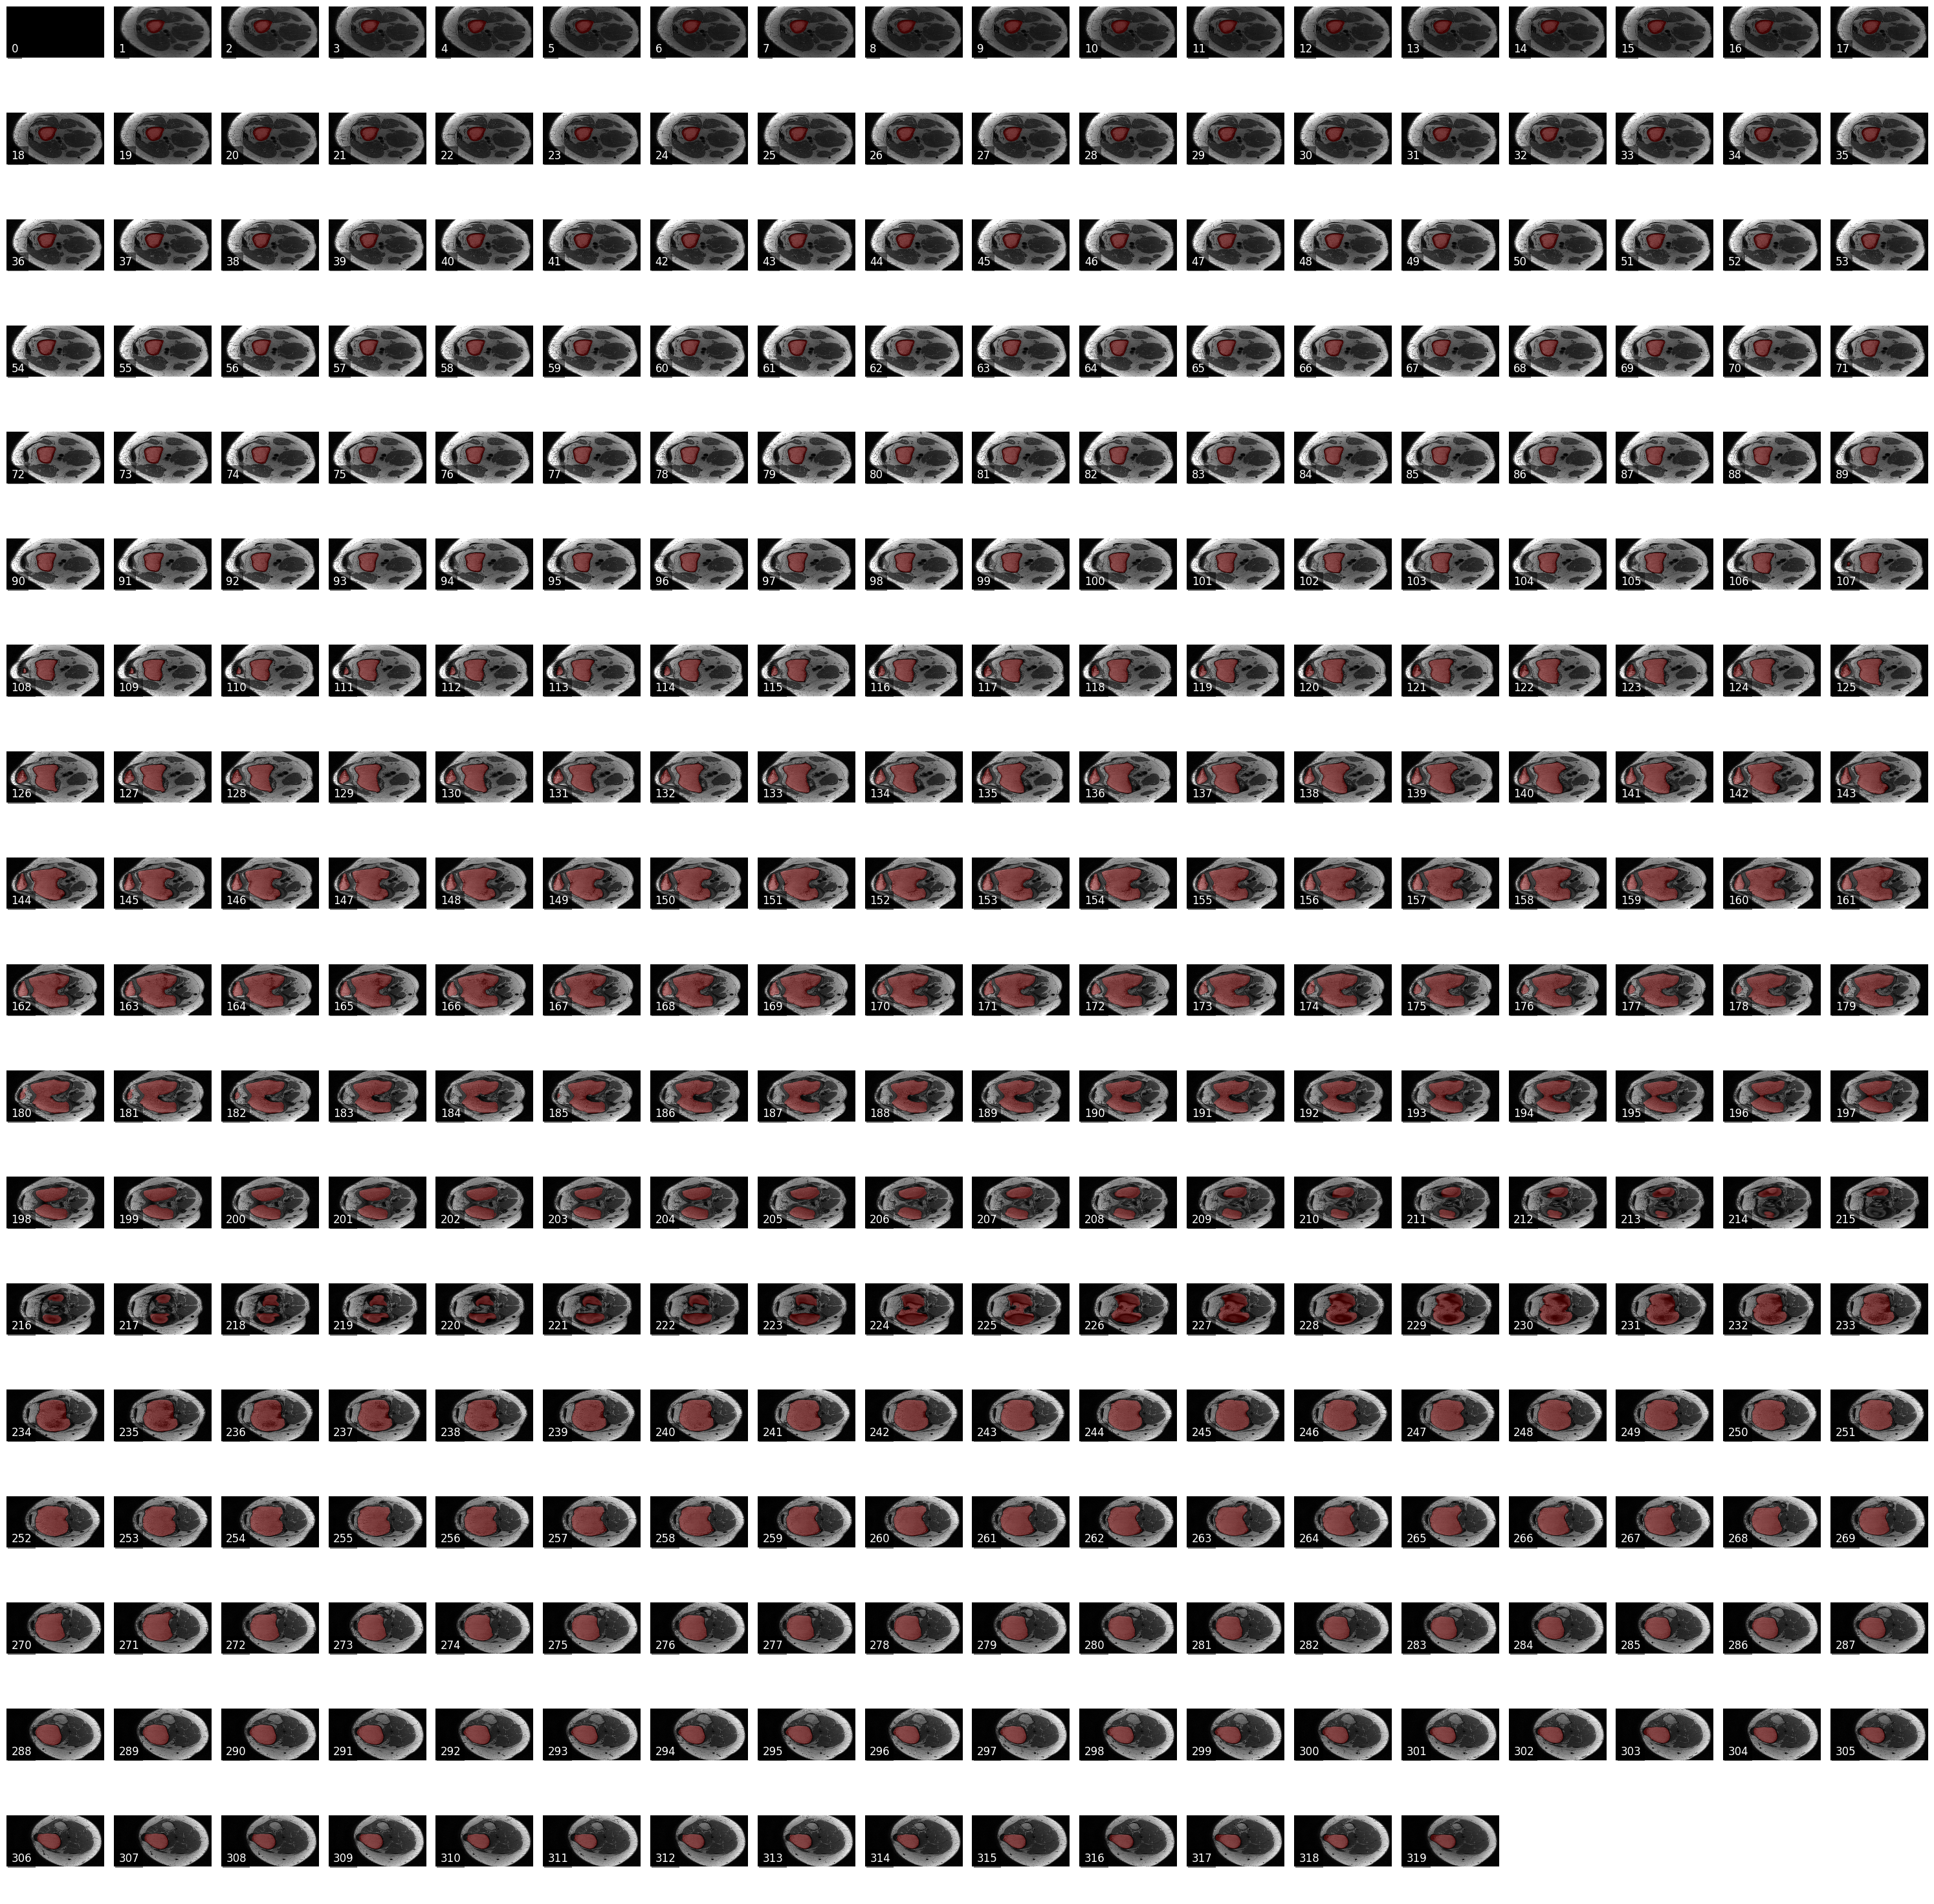

In [15]:
m3d(ret['img'].moveaxis(2,0), pred, figsize=(30, 30))

<Axes: >

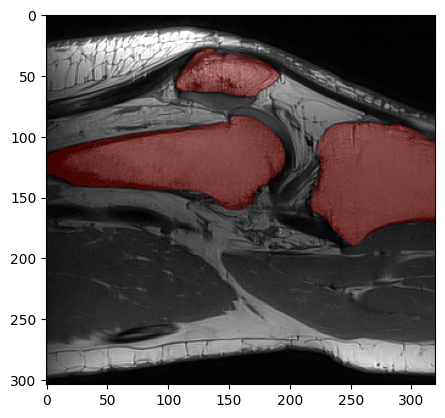

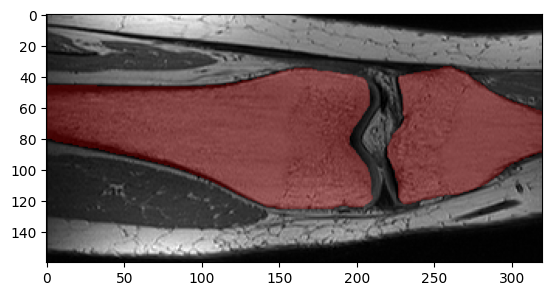

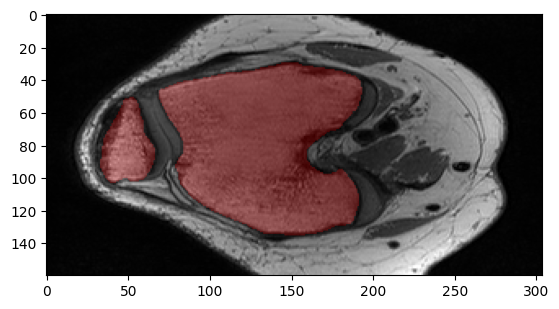

In [12]:
show(ret['img'].moveaxis(0,0)[ret['sag_ndx']], ret['sag_mask'])
show(ret['img'].moveaxis(1,0)[ret['cor_ndx']], ret['cor_mask'])
show(ret['img'].moveaxis(2,0)[ret['ax_ndx']], ret['ax_mask'])
